In [ ]:
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import textwrap
import networkx as nx
import plotly.graph_objects as go
import pingouin as pg

from googleapiclient.discovery import build
from google.oauth2.service_account import Credentials

# 0. Import & Preprocess Data

Importing data from survey's form responses and CPL's data in google sheets

### Functions

In [8]:
def get_credentials(cred_file, scopes):
  cred = Credentials.from_service_account_file(cred_file, scopes=scopes)
  return cred

def build_sheet(cred):
  service = build('sheets', 'v4', credentials=cred)
  sheet = service.spreadsheets()
  return sheet

def read_sheets(sheet, sheet_id, range, columns=None):
  result = sheet.values().get(spreadsheetId=sheet_id, range=range).execute()
  rows = result.get('values', [])
  if columns is None and len(rows) >= 0:
    columns = rows[0]
  elif columns:
    columns = columns
  else:
    print('If sheet is empty, provide column names')
    return
  data = rows[1:] if len(rows) > 1 else []
  df = pd.DataFrame(data, columns=columns)
  return df

def write_to_sheets(sheet, sheet_id, range, values):
  data = {'values': values}
  sheet.values().update(
      spreadsheetId=sheet_id,
      range=range,
      valueInputOption="RAW",
      body=data
  ).execute()
  print('Data berhasil ditulis')

def delete_range(sheet, sheet_id, range):
  sheet.values().clear(
      spreadsheetId=sheet_id,
      range=range
  ).execute()

### Import

In [9]:
CRED_PATH = 'credentials/bw2024-96e33661eb9c.json'
SCOPES = ['https://www.googleapis.com/auth/spreadsheets']

credentials = get_credentials(cred_file=CRED_PATH, scopes=SCOPES)
sheet = build_sheet(cred=credentials)

In [10]:
# List out Sheet IDs

# CPL Database (CPL, Sub-CPL, Quality, Indicator, Question)
CPL_DATABASE_SHEET_ID = '1LXCK0rTLnyMPfPxBtd6hCdN31eLuT8URFtVJZyQCm8w'

# Database Pertanyaan Lain
OTHER_QS_SHEET_ID = '1koJUPQrX4OZWozyqiaMP0ngeqimSMEnES5KnEKH9eFM'

# Students' Responses
# PRE (July - Oct 2025)
RESPONSES_1_SHEET_ID = "1eIGG7ENSJ0nWCcpK034N42ghBsDTcsvNDkVMusivGAI"
RESPONSES_2_SHEET_ID = "1YyHndDwrw4nlnHAurdGrRoaRvRxNCR5OlkUmhXZTUq4"
RESPONSES_3_SHEET_ID = "1Jh5253lqyhCRjfa-uFTRezaFU8G3_E-9eccXbh72fwY"
# POST (Dec 2025 - Jan 2026)
RESPONSES_4_SHEET_ID = "17DndmbzO-raSOe4IdoHyvgqWVuLdgxPDoimc3KQ9ios"


In [22]:
cpl_db1_df = read_sheets(sheet=sheet, sheet_id=CPL_DATABASE_SHEET_ID, range="CPL & Quality")
cpl_db2_df = read_sheets(sheet=sheet, sheet_id=CPL_DATABASE_SHEET_ID, range="Question")

cpl_db1_df = cpl_db1_df.drop(columns=['Indikator'])

cpl_db1_df = cpl_db1_df.replace('', np.nan)
cpl_db1_df = cpl_db1_df.ffill()

cpl_db2_df = cpl_db2_df.replace('', np.nan)
cpl_db2_df = cpl_db2_df.ffill()

cpl_db1_df = cpl_db1_df.merge(cpl_db2_df[['Quality', 'Kualitas']], on="Quality", how='left')

other_qs_df = read_sheets(sheet=sheet, sheet_id=OTHER_QS_SHEET_ID, range="Pertanyaan")

C:\Users\PC\AppData\Local\Temp\ipykernel_11532\2741052615.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cpl_db1_df = cpl_db1_df.replace('', np.nan)


In [70]:
pre_1_responses_df = read_sheets(sheet=sheet, sheet_id=RESPONSES_1_SHEET_ID, range="Form Responses 1!A:DW")
pre_2_responses_df =read_sheets(sheet=sheet, sheet_id=RESPONSES_2_SHEET_ID, range="Form Responses 1!A:CX")
pre_3_responses_df = read_sheets(sheet=sheet, sheet_id=RESPONSES_3_SHEET_ID, range="Form Responses 1!A:V")
post_responses_df = read_sheets(sheet=sheet, sheet_id=RESPONSES_4_SHEET_ID, range="Form Responses 1!A:EN")

# Drop NaNs
pre_1_responses_df = pre_1_responses_df.dropna()
pre_2_responses_df = pre_2_responses_df.dropna()
pre_3_responses_df = pre_3_responses_df.dropna()
post_responses_df = post_responses_df.dropna()

# Create NRP col & filter out non-angkatan 25 students
pre_1_responses_df['NRP'] = pre_1_responses_df['Email Address'].str[:9]
pre_2_responses_df['NRP'] = pre_2_responses_df['Email Address'].str[:9]
pre_3_responses_df['NRP'] = pre_3_responses_df['Email Address'].str[:9]
post_responses_df['NRP'] = post_responses_df['Email Address'].str[:9]

pre_1_responses_df = pre_1_responses_df.drop(columns=['Email Address'])
pre_2_responses_df = pre_2_responses_df.drop(columns=['Email Address'])
pre_3_responses_df = pre_3_responses_df.drop(columns=['Email Address'])
post_responses_df = post_responses_df.drop(columns=['Email Address'])

pre_1_responses_df = pre_1_responses_df[pre_1_responses_df['NRP'].str.contains(r'^.{3}25', regex=True, na=False)]
pre_2_responses_df = pre_2_responses_df[pre_2_responses_df['NRP'].str.contains(r'^.{3}25', regex=True, na=False)]
pre_3_responses_df = pre_3_responses_df[pre_3_responses_df['NRP'].str.contains(r'^.{3}25', regex=True, na=False)]
post_responses_df = post_responses_df[post_responses_df['NRP'].str.contains(r'^.{3}25', regex=True, na=False)]

# Slice demography columns
demografi_qs = other_qs_df[other_qs_df['Kategori']=='Demografi']['Pertanyaan'].values
demografi_df = pre_1_responses_df[demografi_qs]

# Unpivot
pre_1_responses_df = pd.melt(pre_1_responses_df, id_vars=['Timestamp', 'NRP'], var_name='Question', value_name='Answer')
pre_2_responses_df = pd.melt(pre_2_responses_df, id_vars=['Timestamp', 'NRP'], var_name='Question', value_name='Answer')
pre_3_responses_df = pd.melt(pre_3_responses_df, id_vars=['Timestamp', 'NRP'], var_name='Question', value_name='Answer')
post_responses_df = pd.melt(post_responses_df, id_vars=['Timestamp', 'NRP'], var_name='Question', value_name='Answer')

# Filter questions that only exist in CPL DB
pre_1_responses_df_copy = pre_1_responses_df.copy()
questions = cpl_db2_df['Pertanyaan'].unique().tolist()
pre_1_responses_df = pre_1_responses_df[pre_1_responses_df['Question'].isin(questions)].reset_index(drop=True)
pre_2_responses_df = pre_2_responses_df[pre_2_responses_df['Question'].isin(questions)].reset_index(drop=True)
pre_3_responses_df = pre_3_responses_df[pre_3_responses_df['Question'].isin(questions)].reset_index(drop=True)
post_responses_df = post_responses_df[post_responses_df['Question'].isin(questions)].reset_index(drop=True)

# Filter questions that exist in other questions DB
questions = other_qs_df[other_qs_df['Kategori']!='Demografi']['Pertanyaan'].values
other_responses_df = pre_1_responses_df_copy[pre_1_responses_df_copy['Question'].isin(questions)].reset_index(drop=True)


# Concat all pre responses
pre_responses_df = pd.concat([pre_1_responses_df, pre_2_responses_df, pre_3_responses_df], axis=0)

# Turn to int
post_responses_df['Answer']= post_responses_df['Answer'].astype(int)
pre_responses_df['Answer']= pre_responses_df['Answer'].astype(int)

# Flip answer for flipped questions
flipped_questions = cpl_db2_df[cpl_db2_df['Flipped']=='TRUE']['Pertanyaan'].values
post_responses_df['Answer'] = post_responses_df.apply(lambda row: 11-row['Answer'] if row['Question'] in flipped_questions else row['Answer'], axis=1)
pre_responses_df['Answer'] = pre_responses_df.apply(lambda row: 11-row['Answer'] if row['Question'] in flipped_questions else row['Answer'], axis=1)
# Add kualitas column
post_responses_df = post_responses_df.merge(cpl_db2_df[['Pertanyaan', 'Kualitas', 'Aspek Whole Person Education']], left_on='Question', right_on='Pertanyaan', how='left')
post_responses_df.drop(columns=['Pertanyaan'], inplace=True)

pre_responses_df = pre_responses_df.merge(cpl_db2_df[['Pertanyaan', 'Kualitas', 'Aspek Whole Person Education']], left_on='Question', right_on='Pertanyaan', how='left')
pre_responses_df.drop(columns=['Pertanyaan'], inplace=True)


### Jumlah Responden

Survey Juli - Oktober 2025

In [13]:
pre_responses_df['NRP'].nunique()

1022

Survey Juli-Oktober 2025, yang mengisi semua pertanyaan

In [14]:
qs_per_nrp = pre_responses_df.groupby("NRP")['Question'].count().reset_index()
valid_nrps = qs_per_nrp[qs_per_nrp['Question'] ==138]['NRP'].values
len(valid_nrps)

15

Survey Desember 2025 - Januari 2026

In [16]:
post_responses_df['NRP'].nunique()

525

# 1. Exploratory Data Analysis

## 1.A. Analisis Demografi Mahasiswa Baru

Demografi mahasiswa baru didapatkan dari survey yang dibagikan pada Juli 2025, bukan Desember 2025.

### Functions

In [7]:
demografi_cols = list(set(demografi_df.columns) - set(['NRP', 'Nama Lengkap (Full Name)']))

def plot_pie_chart(df, col):
    counts = df[col].value_counts()
    
    fig = px.pie(
        names=counts.index, 
        values=counts.values, 
        title=f'Distribution of {col} (Pie Chart)',
        hole=0.3 
    )
    fig.update_traces(textposition='inside', textinfo='percent+label', insidetextorientation='horizontal')
    fig.show()

def plot_vertical_bar(df, col, max_label_width=20):
    counts = df[col].value_counts()
    df_counts = counts.reset_index()
    df_counts.columns = [col, 'Frequency']
    df_counts[col] = df_counts[col].astype(str).apply(
        lambda x: '<br>'.join(textwrap.wrap(x, width=max_label_width))
    )

    fig = px.bar(
        df_counts, 
        x=col, 
        y='Frequency',
        title=f'Distribution of {col} (Bar Chart)',
        text='Frequency', 
        color='Frequency',
        color_continuous_scale='Blues'
    )
    
    fig.update_xaxes(type='category', categoryorder='array', categoryarray=df_counts[col])
    fig.update_xaxes(
        range=[-0.5, 4.5], 
        rangeslider=dict(visible=True)
    )
    fig.update_traces(textposition='outside')
    
    fig.update_layout(
        width=1000, 
        height=600
    )
    
    fig.show()

def plot_word_cloud(df, col):
    counts = df[col].value_counts()
    wc = WordCloud(width=800, height=400, background_color='white', 
                           colormap='viridis', max_words=100)
    wc.generate_from_frequencies(counts)
    
    fig = px.imshow(wc.to_array(), title=f'Word Cloud of {col}')
    fig.update_xaxes(visible=False)
    fig.update_yaxes(visible=False)
    fig.show()
    
def plot_grouped_vertical_bar(df, col, group_col, max_label_width=20):
    df_counts = df.groupby([col, group_col]).size().reset_index(name='Frequency')
    
    total_counts = df[col].value_counts().reset_index()
    total_counts.columns = [col, 'Total']
   
    df_counts[col] = df_counts[col].astype(str).apply(
        lambda x: '<br>'.join(textwrap.wrap(x, width=max_label_width))
    )
    total_counts[col] = total_counts[col].astype(str).apply(
        lambda x: '<br>'.join(textwrap.wrap(x, width=max_label_width))
    )
  
    sorted_categories = total_counts[col].tolist()
    fig = px.bar(
        df_counts, 
        x=col, 
        y='Frequency',
        color=group_col,
        barmode='group',
        title=f'Distribution of {col} grouped by {group_col}',
        text='Frequency', 
        color_discrete_sequence=px.colors.qualitative.Pastel
    )
    
    fig.update_xaxes(type='category', categoryorder='array', categoryarray=sorted_categories)
    fig.update_xaxes(
        range=[-0.5, 4.5], 
        rangeslider=dict(visible=True)
    )
    fig.update_traces(textposition='outside')
    
    fig.update_layout(
        width=1000, 
        height=600,
        legend_title_text=group_col
    )
    
    fig.show()

### Distribusi Jurusan

In [27]:
plot_vertical_bar(demografi_df, 'Jurusan (Major)')

### Distribusi Jenis Kelamin

In [22]:
plot_pie_chart(demografi_df, 'Jenis Kelamin (Sex)')

### Distribusi Suku

In [28]:
plot_vertical_bar(demografi_df, 'Suku (ethnic)')

### Distribusi Asal Provinsi

In [30]:
plot_vertical_bar(demografi_df, 'Asal Provinsi (Province of origin)')

### Distribusi Asal Kota dari Asal Provinsi Jawa Timur

In [32]:
plot_vertical_bar(demografi_df[demografi_df['Asal Provinsi (Province of origin)']=='Jawa Timur'], 'Asal Kota (City of Origin)')

### Distribusi Asal Kota Dari Asal Provinsi Bukan Jawa Timur

In [34]:
plot_vertical_bar(demografi_df[demografi_df['Asal Provinsi (Province of origin)']!='Jawa Timur'], 'Asal Kota (City of Origin)')

### Distribusi Asal Kota SMA

In [35]:
plot_vertical_bar(demografi_df, "Asal Kota SMA")

### Distribusi Agama

In [36]:
plot_vertical_bar(demografi_df, 'Agama')

### Distribusi Aliran Gereja Asal

In [29]:
plot_vertical_bar(demografi_df[demografi_df['Aliran Gereja Asal']!=""], 'Aliran Gereja Asal')

### Distribusi Aliran Gereja di Surabaya

In [37]:
plot_vertical_bar(demografi_df[demografi_df['Aliran Gereja di Surabaya']!=""], 'Aliran Gereja di Surabaya')

### Distribusi Jenis Kelamin Dalam Setiap Jurusan

In [39]:
plot_grouped_vertical_bar(demografi_df, 'Jurusan (Major)', 'Jenis Kelamin (Sex)')

### Distribusi Aliran Gereja di Surabaya Untuk Yang Berpindah Aliran Gereja

In [40]:
plot_vertical_bar(demografi_df[demografi_df['Aliran Gereja di Surabaya']!=demografi_df['Aliran Gereja Asal']], 'Aliran Gereja di Surabaya')

## 1.B. Analisis Jawaban Survey

### Validasi Reliabilitas Survey

In [47]:
def get_cronbach_alpha(df):
  alpha, interval = pg.cronbach_alpha(data=df)
  return alpha, interval

In [27]:
qualities = post_responses_df['Kualitas'].unique()
quality_alphas = []
for quality in qualities:
    responses_df = post_responses_df[post_responses_df['Kualitas']==quality][['NRP', 'Question', 'Answer']]
    responses_df = responses_df.pivot(index='NRP', columns='Question', values='Answer').reset_index().drop(columns=['NRP'])
    alpha = get_cronbach_alpha(responses_df)
    quality_alphas.append({"Quality": quality, "Cronbach's Alpha": alpha[0]})

pd.DataFrame(quality_alphas)

,Quality,Cronbach's Alpha
0,Penalaran Dasar,0.776935
1,Penalaran Filosofis,0.679921
2,Asertivitas Dasar,0.837472
3,Argumentasi Filosofis,0.831753
4,Altruis,0.851991
5,Dedikasi dan Komitmen,0.863252
6,Belas Kasih,0.810308
7,Kepemimpinan,0.899876
8,Penyesuaian Response Diri,0.788340
9,Keterbukaan Pikiran,0.788570


Notes on Berpikir Kritis Analitis:

Low alpha caused by one reversed question item. If this question were to be removed, alpha would go up to 0.6842

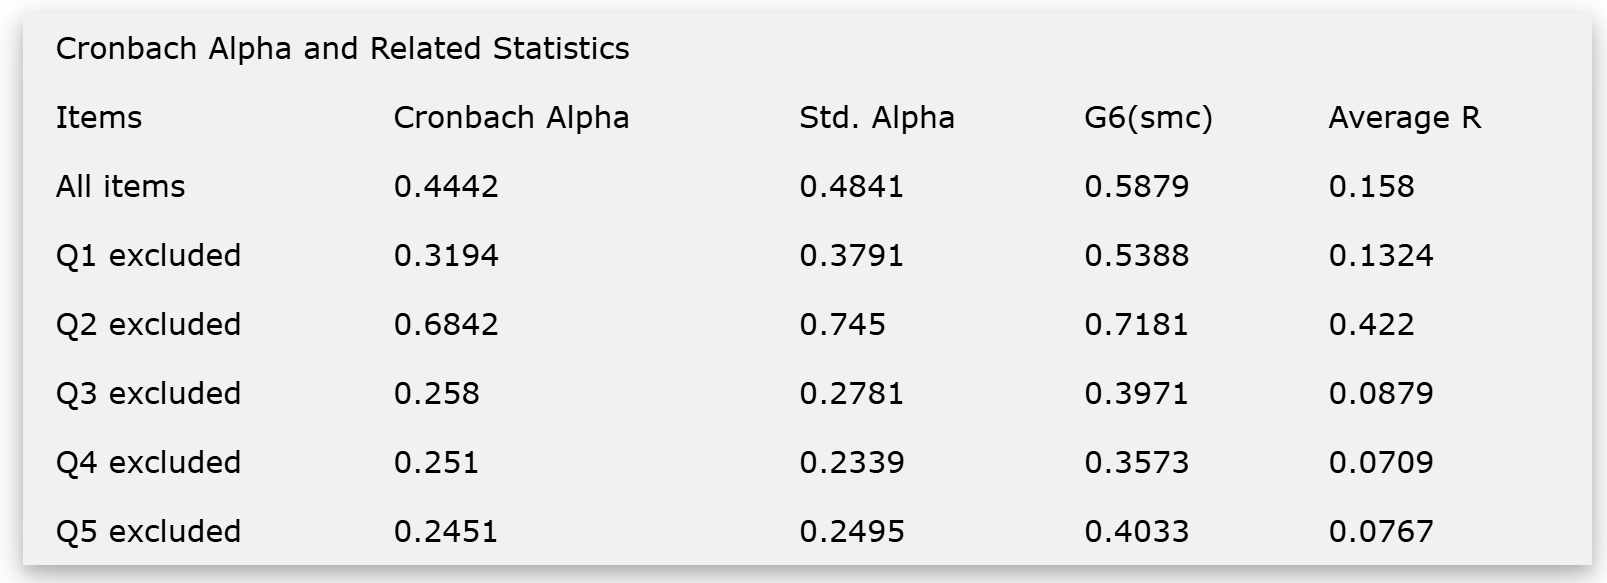

### Skor Quality, Sub-CPL, dan CPL

#### Visualization Function

In [58]:
def plot_aggregated_bar(df, x_col, y_col, max_label_width=20, title=None):
    plot_df = df.copy()
    plot_df = plot_df.sort_values(by=y_col, ascending=False).reset_index(drop=True)
    plot_df['Text_Label'] = plot_df[y_col].round(2).astype(str)
    plot_df[x_col] = plot_df[x_col].astype(str).apply(
        lambda x: '<br>'.join(textwrap.wrap(x, width=max_label_width))
    )
    if title is None:
        title = f'{y_col} per {x_col}'
    fig = px.bar(
        plot_df, 
        x=x_col, 
        y=y_col,
        title=title,
        text='Text_Label',
        color=y_col,
        color_continuous_scale='Blues'
    )

    fig.update_xaxes(type='category', categoryorder='array', categoryarray=plot_df[x_col])
    fig.update_xaxes(
        range=[-0.5, 4.5], 
        rangeslider=dict(visible=True)
    )

    max_score = plot_df[y_col].max()
    fig.update_yaxes(range=[0, max_score * 1.15])
    fig.update_traces(
        textposition='outside', 
        cliponaxis=False
    )
    fig.update_traces(textposition='outside')
    fig.update_layout(
        width=1000, 
        height=600
    )
    fig.show()

#### Calculation

In [39]:
quality_df = post_responses_df.groupby('Kualitas')['Answer'].mean().reset_index().sort_values(by='Answer', ascending=False)
quality_df.rename(columns={"Answer": "Score"}, inplace=True)
merged_df = cpl_db1_df.merge(quality_df, on='Kualitas')
merged_df['Bobot']=merged_df['Bobot'].fillna(1.0)
merged_df['Weighted_Value'] = merged_df['Bobot'] * merged_df['Score']
subcpl_df = merged_df.groupby(['Sub-Capaian Pembelajaran Lulusan', 'Deskripsi Sub-Capaian Pembelajaran Lulusan']).agg(
        Total_Weighted_Value=('Weighted_Value', 'sum'),
        Total_Weight=('Bobot', 'sum')
    ).reset_index()
subcpl_df['Final_Score'] = subcpl_df['Total_Weighted_Value'] / subcpl_df['Total_Weight']
subcpl_df['Sub-CPL'] = subcpl_df['Sub-Capaian Pembelajaran Lulusan'] + " " + subcpl_df['Deskripsi Sub-Capaian Pembelajaran Lulusan']
subcpl_df.drop(columns=['Sub-Capaian Pembelajaran Lulusan', 'Deskripsi Sub-Capaian Pembelajaran Lulusan'], inplace=True)
subcpl_df = subcpl_df.sort_values(by='Final_Score', ascending=False)
cpl_df = merged_df.groupby(['Capaian Pembelajaran Lulusan', 'Deskripsi Capaian Pembelajaran Lulusan']).agg(
        Total_Weighted_Value=('Weighted_Value', 'sum'),
        Total_Weight=('Bobot', 'sum')
    ).reset_index()
cpl_df['Final_Score'] = cpl_df['Total_Weighted_Value'] / cpl_df['Total_Weight']
cpl_df['CPL'] = cpl_df['Capaian Pembelajaran Lulusan'] + " " + cpl_df['Deskripsi Capaian Pembelajaran Lulusan']
cpl_df.drop(columns=['Capaian Pembelajaran Lulusan', 'Deskripsi Capaian Pembelajaran Lulusan'], inplace=True)
cpl_df = cpl_df.sort_values(by='Final_Score', ascending=False)

#### Visualization

In [59]:
plot_aggregated_bar(quality_df, "Kualitas", "Score")

In [60]:
plot_aggregated_bar(subcpl_df, "Sub-CPL", "Final_Score")

In [61]:
plot_aggregated_bar(cpl_df, "CPL", "Final_Score")

### Korelasi Antar Kualitas

#### Function

In [125]:
def plot_correlation(df, category_col='Kualitas', answer_col='Answer', respondent_col='Respondent_ID'):
    df_wide = df.pivot_table(
        index=respondent_col, 
        columns=category_col, 
        values=answer_col
    )

    corr_matrix = df_wide.corr()
    
    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    stacked_corr = corr_matrix.where(mask).stack()
    stacked_corr.index.names = ['Quality 1', 'Quality 2']
    corr_pairs = stacked_corr.reset_index(name='Correlation')
    
    corr_pairs_sorted = corr_pairs.sort_values(by='Correlation', ascending=False)
    
    print("=== TOP 5 HIGHEST PAIRWISE CORRELATIONS ===")
    print(corr_pairs_sorted.head(5).to_string(index=False))
    print("\n=== BOTTOM 5 LOWEST PAIRWISE CORRELATIONS ===")
    print(corr_pairs_sorted.tail(5).to_string(index=False))
    print("\n")
    
    item_rest_results = []
    for quality in df_wide.columns:
        item_scores = df_wide[quality]
        rest_scores = df_wide.drop(columns=[quality]).sum(axis=1)
        corr = item_scores.corr(rest_scores)
        item_rest_results.append((quality, corr))
        
    item_rest_df = pd.DataFrame(item_rest_results, columns=['Quality', 'Item-Rest Correlation'])
    item_rest_df = item_rest_df.sort_values(by='Item-Rest Correlation', ascending=False).reset_index(drop=True)
    
    print("=== TOP 5 HIGHEST ITEM-TOTAL CORRELATIONS (Strongest Core Traits) ===")
    print(item_rest_df.head(5).to_string(index=False))
    
    print("\n=== BOTTOM 5 LOWEST ITEM-TOTAL CORRELATIONS (The 'Lone Wolves') ===")
    print(item_rest_df.tail(5).to_string(index=False))
    print("\n" + "="*45 + "\n")
   
    fig = px.imshow(
        corr_matrix,
        text_auto=".2f",
        aspect="auto",
        color_continuous_scale="RdBu_r",
        zmin=-1, zmax=1,
        title="Correlation Heatmap Between Qualities",
        labels=dict(color="Correlation")
    )
    
    # 4. Clean up the Layout
    fig.update_layout(
        xaxis_title="",
        yaxis_title="",
        xaxis_tickangle=-45,
        width=900,
        height=800,
        margin=dict(l=150, b=150)
    )
    
    fig.show()
    
    return corr_matrix

def plot_correlation_network(corr_matrix, threshold=0.3):
    G = nx.Graph()
    for col in corr_matrix.columns:
        G.add_node(col)
    columns = corr_matrix.columns
    for i in range(len(columns)):
        for j in range(i + 1, len(columns)):
            weight = corr_matrix.iloc[i, j]
            if abs(weight) >= threshold:
                G.add_edge(columns[i], columns[j], weight=weight)
 
    pos = nx.spring_layout(G, seed=42, k=0.5)
    fig = go.Figure()

    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        weight = edge[2]['weight']
    
        line_color = 'royalblue' if weight > 0 else 'firebrick'
        line_width = abs(weight) * 5 
        
        fig.add_trace(go.Scatter(
            x=[x0, x1, None], 
            y=[y0, y1, None],
            line=dict(width=line_width, color=line_color),
            hoverinfo='text',
            text=f"{edge[0]} & {edge[1]}<br>Corr: {weight:.2f}",
            mode='lines',
            showlegend=False
        ))

    node_x = []
    node_y = []
    node_text = []
    
    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        degree = G.degree(node)
        node_text.append(f"<b>{node}</b><br>Connections: {degree}")

    fig.add_trace(go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        textposition="top center",
        textfont=dict(size=10, color='black'),
        hoverinfo='text',
        hovertext=node_text,
        marker=dict(
            showscale=False,
            color='lightgreen',
            size=30,
            line_width=2,
            line_color='darkgreen'
        ),
        text=[node for node in G.nodes()],
        showlegend=False
    ))
    fig.update_layout(
        title=dict(
            text=f'Quality Correlation Network (Threshold: {threshold})',
            font=dict(size=16)
        ),
        showlegend=False,
        hovermode='closest',
        margin=dict(b=20, l=5, r=5, t=40),
        plot_bgcolor='white',
        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
        width=900,
        height=700
    )
    
    fig.show()

#### Tables & Plot

In [124]:
corr_matrix = plot_correlation(post_responses_df, 'Kualitas', 'Answer', 'NRP')

=== TOP 5 HIGHEST PAIRWISE CORRELATIONS ===
        Quality 1            Quality 2  Correlation
Berpikir Sistemik    Ilmu Sosial Dasar     0.761355
Berpikir Analitis    Ilmu Sosial Dasar     0.736200
Berpikir Analitis         Kepemimpinan     0.722533
          Altruis          Belas Kasih     0.720879
Berpikir Analitis Komunikasi Penyajian     0.694169

=== BOTTOM 5 LOWEST PAIRWISE CORRELATIONS ===
                Quality 1                 Quality 2  Correlation
        Keterampilan Ahli Penyesuaian Response Diri    -0.205252
Pemecahan Masalah Kreatif Penyesuaian Response Diri    -0.215901
        Penyajian Kreatif Penyesuaian Response Diri    -0.225604
Pemecahan Masalah Kreatif      Perspektif Kekekalan    -0.237094
    Argumentasi Filosofis Penyesuaian Response Diri    -0.275946


=== TOP 5 HIGHEST ITEM-TOTAL CORRELATIONS (Strongest Core Traits) ===
           Quality  Item-Rest Correlation
      Kepemimpinan               0.832301
 Berpikir Analitis               0.808687
 Berpikir

#### Correlation Network

In [126]:
plot_correlation_network(corr_matrix, threshold=0.4)

# UNUSED

### Clustering Berdasarkan Quality

In [110]:
quality_responses_df = post_responses_df.pivot_table(index='NRP', columns='Kualitas', values='Answer').reset_index()
quality_responses = quality_responses_df.drop(columns=['NRP'])

pca = PCA(n_components=10)
X_pca = pca.fit_transform(quality_responses.values)

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

loadings = pd.DataFrame(
    pca.components_.T, 
    columns=component_names,
    index=quality_responses.columns,
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Kualitas,,,,,,,,,,
Adaptasi,0.151976,0.083596,-0.105007,-0.102940,0.065577,0.155470,0.002898,-0.031059,0.001195,0.021083
Altruis,0.139006,0.062393,-0.009141,-0.200811,-0.028962,0.088456,-0.130400,0.115826,-0.160791,-0.060513
Argumentasi Filosofis,0.221766,-0.199726,0.342754,0.086102,0.012158,0.027829,-0.407261,0.111092,-0.071675,0.317188
Asertivitas Dasar,0.188360,-0.068733,0.091653,0.148157,0.059931,0.114515,-0.233098,0.300630,0.310898,0.118498
Bekerja Dalam Tim,0.147579,0.082403,-0.124423,-0.131423,0.019170,0.149115,0.061733,-0.008169,0.070615,-0.117122
Belas Kasih,0.142086,0.052948,0.010730,-0.257089,-0.016902,0.084566,-0.172672,0.191794,-0.259156,-0.023551
Berorientasi Pada Tujuan,0.196113,0.022827,-0.228236,0.215441,-0.143500,-0.067327,0.015780,0.008904,-0.081827,0.242496
Berpikir Analitis,0.196946,0.016801,0.098806,-0.084579,0.090262,-0.015974,0.048719,0.006226,0.086843,-0.094343
Berpikir Kritis Analitis,0.116525,0.043648,-0.051407,0.023368,0.023434,0.007766,-0.033703,0.042209,0.059874,-0.042938


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

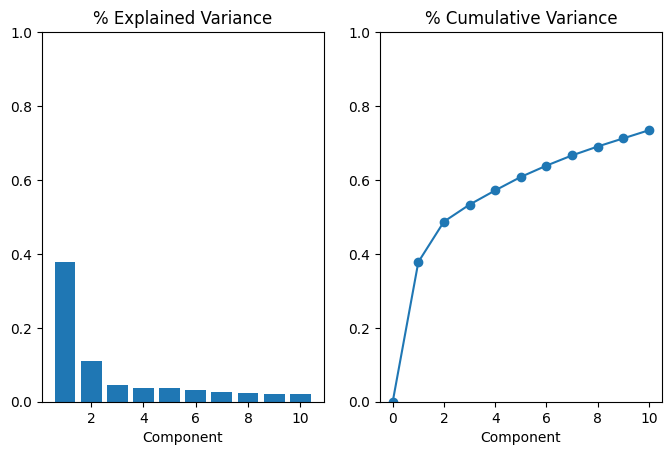

In [111]:
plot_variance(pca)

Tuning K-Means based on Silhouette Score...

k = 2  |  Silhouette Score = 0.2742
k = 3  |  Silhouette Score = 0.1754
k = 4  |  Silhouette Score = 0.1755
k = 5  |  Silhouette Score = 0.1837
k = 6  |  Silhouette Score = 0.1483
k = 7  |  Silhouette Score = 0.1399
k = 8  |  Silhouette Score = 0.1319
k = 9  |  Silhouette Score = 0.1260
k = 10  |  Silhouette Score = 0.1291
-----------------------------------
Optimal number of clusters (k): 2
Best Silhouette Score: 0.2742


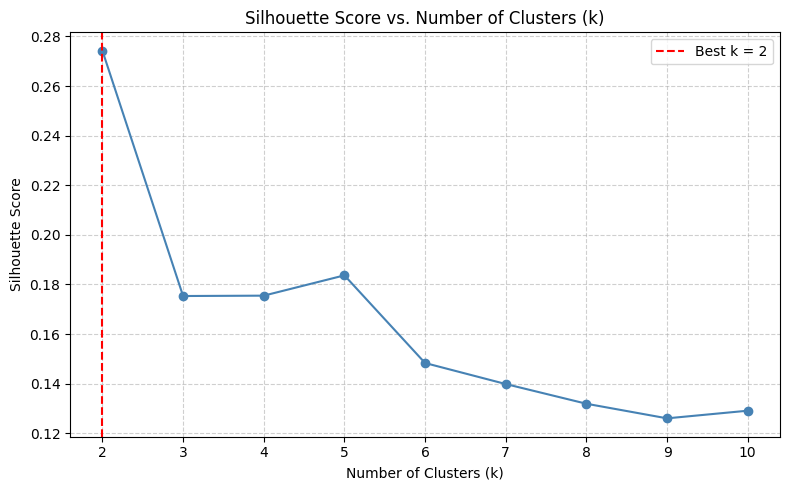

In [112]:
best_k, best_model, final_labels = tune_kmeans_silhouette(X_pca, max_k=10)

In [113]:
best_k, best_model, final_labels = tune_hdbscan_silhouette(X_pca)

Tuning HDBSCAN based on Silhouette Score...

min_cluster_size = 15  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 20  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 25  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 30  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 35  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 40  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 45  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 50  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 55  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 60  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 65  |  Valid Clusters = 0  |  Noise Points = 525  |  Sco

### Clustering Berdasarkan WPE

In [97]:
wpe_responses_df = post_responses_df.pivot_table(index='NRP', columns='Aspek Whole Person Education', values='Answer').reset_index()
wpe_responses = wpe_responses_df.drop(columns=['NRP'])

pca = PCA(n_components=2)
X_pca = pca.fit_transform(wpe_responses.values)

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

loadings = pd.DataFrame(
    pca.components_.T, 
    columns=component_names,
    index=wpe_responses.columns,
)
loadings

,PC1,PC2
Aspek Whole Person Education,,
Intellectual,0.394523,-0.372404
Mentality,0.342566,-0.359066
Physical,0.746810,0.658343
Social,0.343933,-0.399827
Spiritual,0.225800,-0.372975


In [89]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

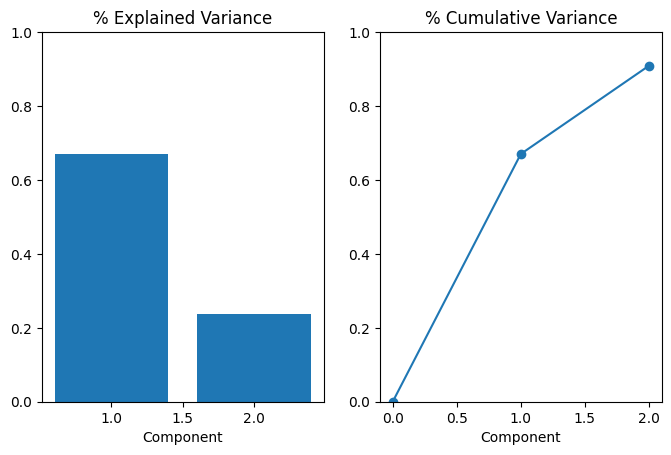

In [76]:
plot_variance(pca)

In [90]:
def tune_kmeans_silhouette(X_pca, max_k=10):
    """
    Finds the optimal number of clusters for KMeans using the Silhouette Score.
    
    Parameters:
    - X_pca: The PCA-transformed dataset (numpy array or pandas DataFrame)
    - max_k: The maximum number of clusters to test (default is 10)
    
    Returns:
    - best_k: The optimal number of clusters
    - best_model: The fitted KMeans model with the optimal k
    - labels: The cluster labels for the optimal model
    """
    
    silhouette_scores = []
    K_range = range(2, max_k + 1) # Silhouette score requires at least 2 clusters
    
    print("Tuning K-Means based on Silhouette Score...\n")
    
    for k in K_range:
        # 1. Initialize and fit KMeans
        # n_init='auto' suppresses future warnings, random_state ensures reproducibility
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_pca)
        
        # 2. Calculate the Silhouette Score
        score = silhouette_score(X_pca, cluster_labels)
        silhouette_scores.append(score)
        print(f"k = {k}  |  Silhouette Score = {score:.4f}")
        
    # 3. Find the optimal k (highest silhouette score)
    best_index = np.argmax(silhouette_scores)
    best_k = K_range[best_index]
    best_score = silhouette_scores[best_index]
    
    print("-" * 35)
    print(f"Optimal number of clusters (k): {best_k}")
    print(f"Best Silhouette Score: {best_score:.4f}")
    
    # 4. Plot the results for visual confirmation
    plt.figure(figsize=(8, 5))
    plt.plot(K_range, silhouette_scores, marker='o', linestyle='-', color='steelblue')
    plt.axvline(x=best_k, color='red', linestyle='--', label=f'Best k = {best_k}')
    plt.title('Silhouette Score vs. Number of Clusters (k)')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.xticks(K_range)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # 5. Retrain the model using the absolute best k
    best_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    best_labels = best_kmeans.fit_predict(X_pca)
    
    return best_k, best_kmeans, best_labels

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import HDBSCAN # Available natively in scikit-learn 1.3+
from sklearn.metrics import silhouette_score

def tune_hdbscan_silhouette(X_pca, max_min_cluster_size=100):
    """
    Finds the optimal min_cluster_size for HDBSCAN using the Silhouette Score.
    
    Parameters:
    - X_pca: The PCA-transformed dataset (numpy array or pandas DataFrame)
    - max_min_cluster_size: The maximum min_cluster_size to test (default is 15)
    
    Returns:
    - best_mcs: The optimal min_cluster_size
    - best_model: The fitted HDBSCAN model
    - labels: The cluster labels (Note: -1 indicates noise/outliers)
    """
    
    silhouette_scores = []
    # min_cluster_size must be at least 2
    mcs_range = range(15, max_min_cluster_size + 1, 5) 
    
    print("Tuning HDBSCAN based on Silhouette Score...\n")
    
    for mcs in mcs_range:
        # 1. Initialize and fit HDBSCAN
        hdb = HDBSCAN(min_cluster_size=mcs)
        cluster_labels = hdb.fit_predict(X_pca)
        
        # 2. HDBSCAN labels noise as -1. We separate noise from actual clusters.
        mask = cluster_labels != -1
        n_clusters = len(set(cluster_labels[mask]))
        noise_count = np.sum(~mask)
        
        # 3. Calculate Silhouette Score (Requires at least 2 valid clusters)
        if n_clusters >= 2:
            # Score only the clustered points
            score = silhouette_score(X_pca[mask], cluster_labels[mask])
        else:
            # If everything is noise or only 1 cluster is found, score is invalid
            score = -1.0 
            
        silhouette_scores.append(score)
        print(f"min_cluster_size = {mcs}  |  Valid Clusters = {n_clusters}  |  Noise Points = {noise_count}  |  Score = {score:.4f}")
        
    # 4. Find the optimal min_cluster_size
    best_index = np.argmax(silhouette_scores)
    best_mcs = mcs_range[best_index]
    best_score = silhouette_scores[best_index]
    
    print("-" * 55)
    if best_score == -1.0:
        print("Warning: HDBSCAN could not find more than 1 distinct cluster across the tested range.")
        return None, None, None
        
    print(f"Optimal min_cluster_size: {best_mcs}")
    print(f"Best Silhouette Score (excluding noise): {best_score:.4f}")
    
    # 5. Plot the results
    plt.figure(figsize=(8, 5))
    plt.plot(mcs_range, silhouette_scores, marker='o', linestyle='-', color='teal')
    plt.axvline(x=best_mcs, color='red', linestyle='--', label=f'Best size = {best_mcs}')
    plt.title('Silhouette Score vs. HDBSCAN min_cluster_size')
    plt.xlabel('min_cluster_size')
    plt.ylabel('Silhouette Score (Excluding Noise)')
    plt.xticks(mcs_range)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
    # 6. Retrain the model using the absolute best min_cluster_size
    best_hdbscan = HDBSCAN(min_cluster_size=best_mcs)
    best_labels = best_hdbscan.fit_predict(X_pca)
    
    return best_mcs, best_hdbscan, best_labels

Tuning HDBSCAN based on Silhouette Score...

min_cluster_size = 15  |  Valid Clusters = 2  |  Noise Points = 419  |  Score = 0.5739
min_cluster_size = 20  |  Valid Clusters = 2  |  Noise Points = 413  |  Score = 0.6040
min_cluster_size = 25  |  Valid Clusters = 2  |  Noise Points = 394  |  Score = 0.5767


min_cluster_size = 30  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 35  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 40  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 45  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 50  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 55  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 60  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 65  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 70  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 75  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 80  |  Valid Clusters = 0  |  Noise Points = 525  |  Score = -1.0000
min_cluster_size = 85  |  Valid 

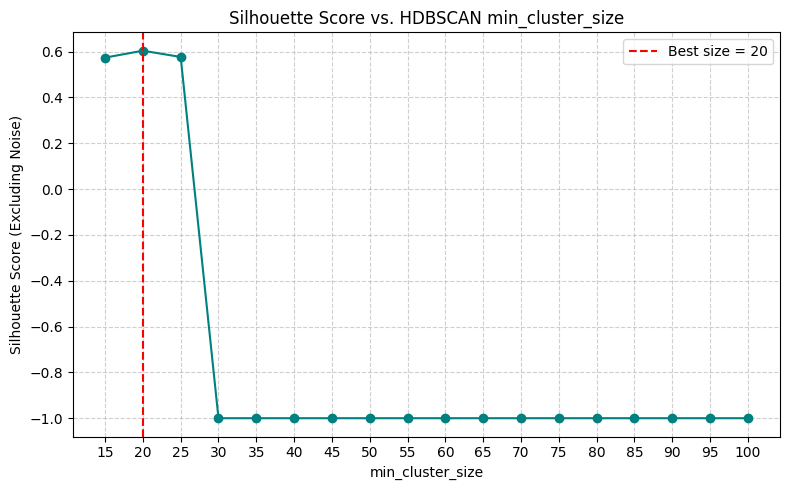

In [101]:
best_k, best_model, final_labels = tune_hdbscan_silhouette(X_pca)

In [102]:
wpe_responses_df['Cluster'] = final_labels
wpe_responses_df.groupby('Cluster')[['Intellectual', 'Mentality', 'Physical', 'Social', 'Spiritual']].mean()

Aspek Whole Person Education,Intellectual,Mentality,Physical,Social,Spiritual
Cluster,,,,,
-1,6.845741,7.201803,6.355125,6.765738,7.523237
0,7.058098,7.285375,7.091954,6.970690,7.478309
1,6.131636,6.591724,5.173333,6.246000,7.037419


Tuning K-Means based on Silhouette Score...

k = 2  |  Silhouette Score = 0.3777
k = 3  |  Silhouette Score = 0.2718
k = 4  |  Silhouette Score = 0.2874
k = 5  |  Silhouette Score = 0.2563
k = 6  |  Silhouette Score = 0.2451
k = 7  |  Silhouette Score = 0.2411
k = 8  |  Silhouette Score = 0.2272
k = 9  |  Silhouette Score = 0.2291
k = 10  |  Silhouette Score = 0.2268
-----------------------------------
Optimal number of clusters (k): 2
Best Silhouette Score: 0.3777


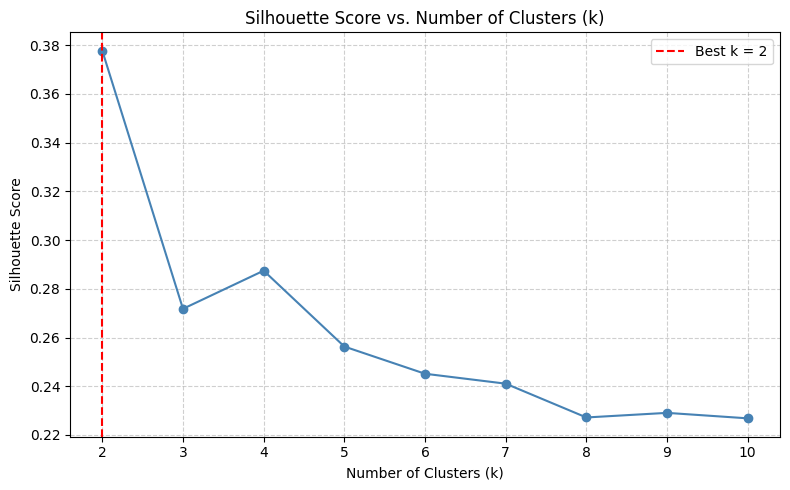

In [91]:
best_k, best_model, final_labels = tune_kmeans_silhouette(X_pca, max_k=10)

In [103]:
import plotly.express as px
import pandas as pd

def plot_pca_clusters(X_pca, labels, pc_x=0, pc_y=1):
    """
    Plots the PCA data points colored by their K-Means cluster.
    
    Parameters:
    - X_pca: Numpy array or DataFrame of PCA transformed data.
    - labels: Array of cluster labels assigned by K-Means.
    - pc_x: The index of the Principal Component for the X-axis (default 0 for PC1).
    - pc_y: The index of the Principal Component for the Y-axis (default 1 for PC2).
    """
    
    # 1. Convert the data into a Pandas DataFrame for Plotly
    # We extract the specific columns for the X and Y axes
    df_plot = pd.DataFrame({
        f'PC{pc_x + 1}': X_pca[:, pc_x] if isinstance(X_pca, np.ndarray) else X_pca.iloc[:, pc_x],
        f'PC{pc_y + 1}': X_pca[:, pc_y] if isinstance(X_pca, np.ndarray) else X_pca.iloc[:, pc_y],
        
        # Convert labels to strings so Plotly treats them as discrete categories, not a continuous color gradient
        'Cluster': labels.astype(str) 
    })
    
    # Sort the dataframe so the legend appears in order (0, 1, 2...)
    df_plot = df_plot.sort_values(by='Cluster')
    
    # 2. Create the interactive scatter plot
    fig = px.scatter(
        df_plot, 
        x=f'PC{pc_x + 1}', 
        y=f'PC{pc_y + 1}',
        color='Cluster',
        title=f'K-Means Clustering mapping (PC{pc_x + 1} vs PC{pc_y + 1})',
        color_discrete_sequence=px.colors.qualitative.Plotly, # Uses distinct colors for each group
        opacity=0.8 # Slightly transparent so overlapping points are visible
    )
    
    # 3. Clean up the Layout
    fig.update_layout(
        xaxis_title=f'Principal Component {pc_x + 1}',
        yaxis_title=f'Principal Component {pc_y + 1}',
        width=900,
        height=700,
        legend_title_text='Cluster Tag',
        plot_bgcolor='white' # Gives it a clean, professional background
    )
    
    # Add subtle grid lines to help with reading coordinates
    fig.update_xaxes(showline=True, linewidth=1, linecolor='black', gridcolor='lightgray')
    fig.update_yaxes(showline=True, linewidth=1, linecolor='black', gridcolor='lightgray')
    
    fig.show()

In [104]:
plot_pca_clusters(X_pca, final_labels)

In [94]:
wpe_responses_df['Cluster'] = final_labels

In [84]:
wpe_responses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   NRP           525 non-null    object 
 1   Intellectual  525 non-null    float64
 2   Mentality     525 non-null    float64
 3   Physical      525 non-null    float64
 4   Social        525 non-null    float64
 5   Spiritual     525 non-null    float64
 6   Cluster       525 non-null    int32  
dtypes: float64(5), int32(1), object(1)
memory usage: 26.8+ KB


In [95]:
wpe_responses_df.groupby('Cluster')[['Intellectual', 'Mentality', 'Physical', 'Social', 'Spiritual']].mean()

Aspek Whole Person Education,Intellectual,Mentality,Physical,Social,Spiritual
Cluster,,,,,
0,7.515021,7.756149,7.866189,7.343728,7.849578
1,6.089209,6.540650,4.781843,6.129878,7.087857


Tuning K-Means based on Silhouette Score...

k = 2  |  Silhouette Score = 0.3777
k = 3  |  Silhouette Score = 0.2718
k = 4  |  Silhouette Score = 0.2874
k = 5  |  Silhouette Score = 0.2563
k = 6  |  Silhouette Score = 0.2451
k = 7  |  Silhouette Score = 0.2411
k = 8  |  Silhouette Score = 0.2272
k = 9  |  Silhouette Score = 0.2291
k = 10  |  Silhouette Score = 0.2268
-----------------------------------
Optimal number of clusters (k): 2
Best Silhouette Score: 0.3777


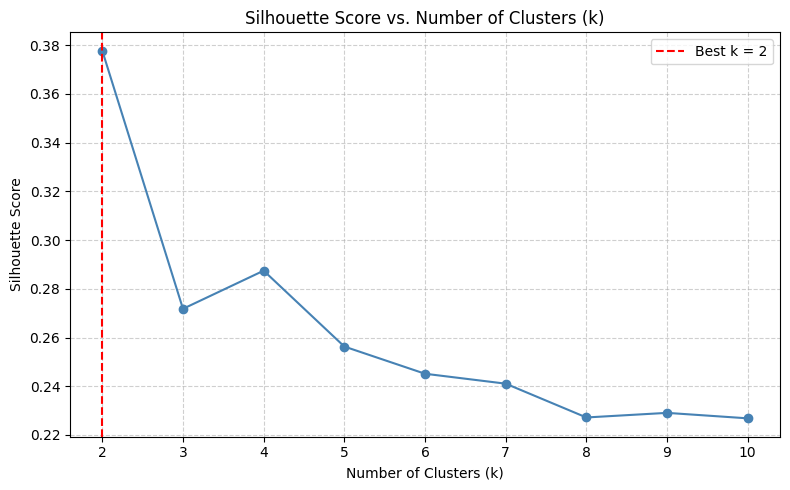

In [80]:
best_k, best_model, final_labels = tune_kmeans_silhouette(wpe_responses, max_k=10)